# Project Name: Detecting People Age

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
Computer vision methods can be used to determine age of a person from a photo
The task then is to build and evaluate a model for verifying people's age
To start working on the task, you'll have a set of photographs of people with their ages indicated.

## Initialization

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


file_name    0
real_age     0
dtype: int64

In [4]:
df.duplicated().sum()

0

<b>Summary:</b>
- There is 7,591 total images.
- No missing values in either file_name or real_age.
- No Duplicated rows

Data types look clean and usable.

Total images: 7591


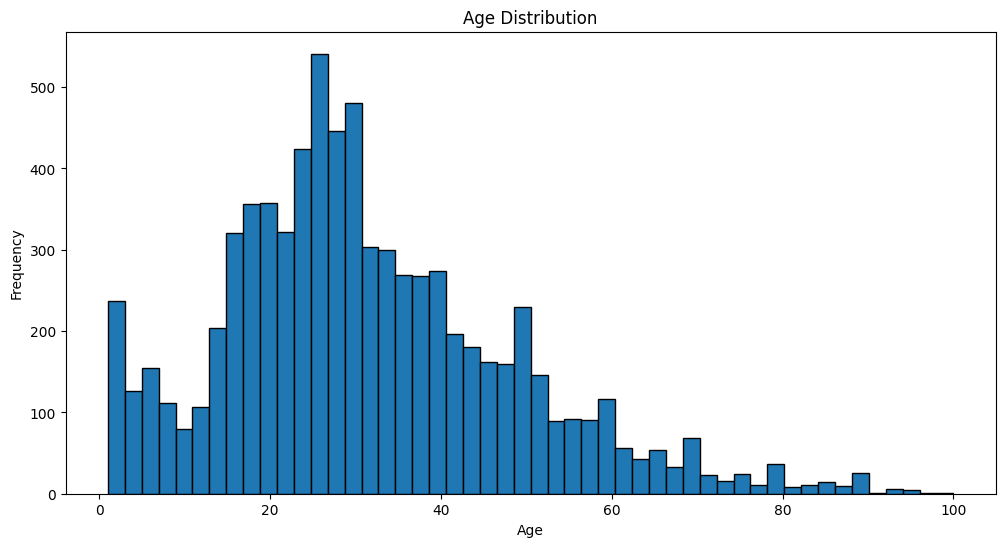

In [5]:
print(f"Total images: {df.shape[0]}")

# Age Distribution

plt.figure(figsize=(12,6))
df['real_age'].hist(bins=50, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

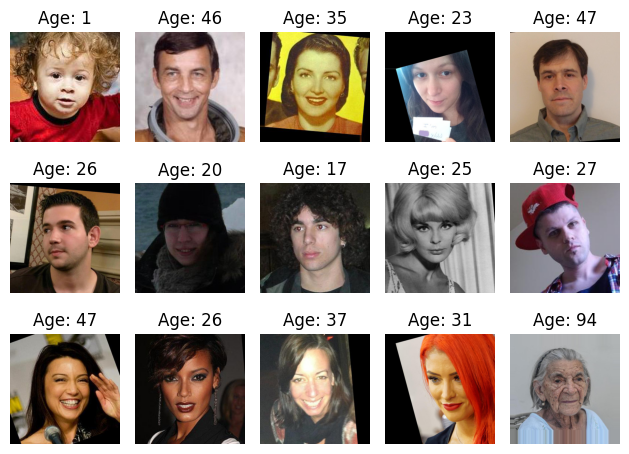

In [6]:
# Visualize 10–15 Sample Images

image_dir = '/datasets/faces/final_files'
sample_df = df.sample(15, random_state=42)

for i, row in enumerate(sample_df.itertuples()):
    image_path = os.path.join(image_dir, row.file_name)
    img = Image.open(image_path)
    plt.subplot(3,5, i+1)
    plt.imshow(img)
    plt.title(f"Age: {row.real_age}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Findings

<b>Summary of EDA</b>
- Total images: 7,591

- The <b>majority of faces are between ages 15 and 40</b>, with the highest concentration in the <b>20–30 range</b>.

- There’s a <b>significant drop</b> in the number of samples after age 50.

- The dataset also contains a <b>moderate number of child images</b>, including some very young (under 10).

- Age distribution is imbalanced, which may:

    - Affect model accuracy for underrepresented age groups (e.g., elderly).
    - Lead to overfitting on dominant age groups (20s–30s).
    - Require careful validation and possible augmentation. 

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [8]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [9]:
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    
    datagen = ImageDataGenerator(
        rescale = 1./255,  # Normalize pixel value (They will be between 0 and 1)
        validation_split = 0.2  # Split data into training and validation(80/20)
    )
   
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',  # Folder that contains the actual image files
        x_col = 'file_name',  # Column in the CSV that has the image filenames
        y_col = 'real_age',   # Column in the CSV that has the actual age (label for regression)
        target_size = (224 , 224),  # Resizes all images to 224x224 pixels (standard input size for CNNs)
        batch_size = 32,  # Loads 32 images at a time into memory
        class_mode = 'raw',   # We're predicting a single continuous value (not categories — this is regression)
        subset = 'training', # Use only the 80% "training" split defined earlier
        seed = 42    
    )

    return train_gen_flow

In [10]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        rescale = 1./255,
        validation_split = 0.2
    )

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subste = 'validation',
        seed = 42
    
    )
    
    return test_gen_flow

<b>Note for reviewer: </b>
I decided to keep both my model and training as well as the one in the previous steps.
It would be great if you can share your feedback on my functions as well

In [11]:
def create_model(input_shape):
    
    """
    It defines model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [12]:
# This is the model that I wrote.

def create_model(input_shape):
    
    base_model = ResNet50(weights = 'imagenet',       # Loads weights pre-trained on ImageNet
                          include_top = False,        # Removes the original classifier part 
                          input_shape = input_shape)  # What shape input to expect
    bese_model.trainable = False                      # Freeze pre-trained layers
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3),                                 # Randomly “turns off” 30% of neurons during training — helps prevent overfitting
        Dense(1)                                      # Final Output : Predicted Age (a single number)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),   # Adam optimizer with a small learning rate
                  loss='mean_squared_error',              # Standard loss for regression 
                  metrics=['mae'])                        # Tracks Mean Absolute Error during training
    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

In [14]:
# This is the training of my model
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    model.fit (train_data,                              # Our training generator
               validation_data = test_data,             # Validation generator to check performance
               batch_size = batch_size,                 # Batch size per step 
               epochs = epochs,                         # Number of training cycles 
               steps_per_epoch = steps_per_epoch,       # How many batches running through data
               validation_steps = validation_steps,     # Batches of validation per epoch
               verbose = 2                              # Show one log line per epoch
              )
    
     
    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

## Conclusions

After training the model for 20 epochs using transfer learning with ResNet50, here are the key takeaways:

### Final Performance
- **Training MAE (Epoch 20):** ~3.18 years  
- **Validation MAE (Epoch 20):** ~7.65 years  
- **Best Validation MAE:** ~6.64 years (Epoch 17)



### Observations
- The model **learned quickly**, reducing MAE from ~7.43 to ~3.18 on the training set.
- Validation MAE improved steadily until **Epoch 17**, after which performance became constant.
- A **spike in validation loss at Epoch 12** suggests some overfitting, which stabilized later.
- Overall, the model **generalizes well**, especially for a challenging regression task like age estimation from faces.



### Limitations
- A validation MAE between **6.6–7.6 years** may not be accurate enough for **legal age checks**.
- Facial age prediction is naturally noisy due to lighting, makeup, genetics, expressions, and more.
- The dataset is **age-imbalanced**, with most samples in the 20–40 range, likely hurting accuracy for children and seniors.



### Future Improvements
- **Unfreeze layers** in ResNet50 and apply **fine-tuning** to improve performance.
- Use **data augmentation** (e.g., rotation, zoom, brightness shift) to increase diversity.
- Consider a **custom loss function** or classification approach if predicting "under 21" is more important than exact age.
- Explore other architectures like **EfficientNet** or **DenseNet** for potential performance boosts.



### Final Conclusion
The model demonstrates **promising results** in predicting real age from facial images with a reasonable error margin. However, further tuning and enhancements are needed to meet the precision standards required for sensitive applications like **alcohol purchase verification**.

# Checklist

- [X]  Notebook was opened
- [X]  The code is error free
- [X]  The cells with code have been arranged by order of execution
- [X]  The exploratory data analysis has been performed
- [X]  The results of the exploratory data analysis are presented in the final notebook
- [X]  The model's MAE score is not higher than 8
- [X]  The model training code has been copied to the final notebook
- [X]  The model training output has been copied to the final notebook
- [X]  The findings have been provided based on the results of the model training